In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 30

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(29.5), np.float64(29.5), np.float64(-0.5))

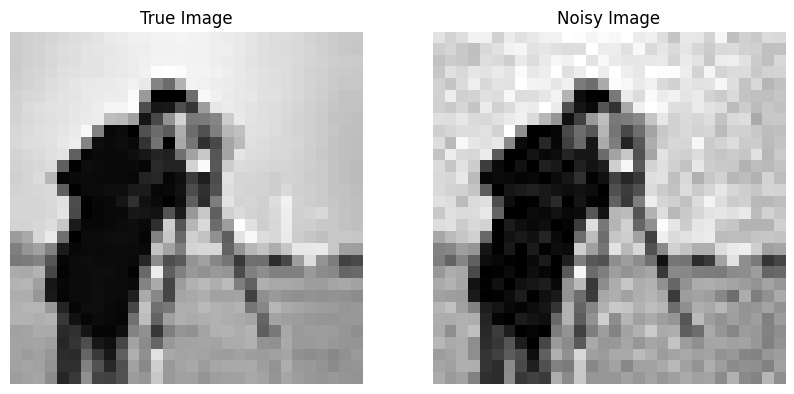

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    14704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2641
                     variables with only lower bounds:      901
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2640
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

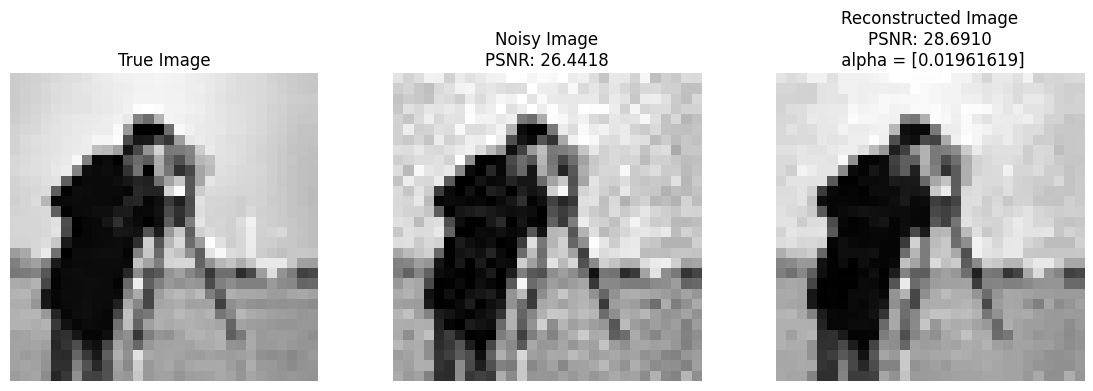

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [ ]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

[0.86182749 0.83735065 0.85708624 ... 0.         0.         0.01961619]


In [ ]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [ ]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

In [14]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [15]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0829234e-01 1.55e+00 2.04e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

0                 1  0.1623091917281392      6.042900361202474                  1.0

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6230919e-01 2.17e-01 7.22e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

1                 1  0.16160788438189166     5.533528320830379                  0.5

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6160788e-01 1.23e-01 4.46e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

2                -1  0.1585801784066316      4.4725823905629305                0.25

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6160788e-01 9.78e-02 4.46e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

3                 1  0.1615467282669176      4.551317344109046                0.275

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6154673e-01 1.26e-01 6.17e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

4                 2  0.17027050589719797     2.7088043686178573      0.12375000000000001

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7027051e-01 6.24e-02 7.39e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5                 1  0.1700705777199556      1.649855460988499       0.05568750000000001

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7007058e-01 3.06e-02 8.99e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

6                 2  0.21583488415621072     0.9746092830749504      0.025059375000000005

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1583488e-01 1.37e-02 9.48e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

7                 1  0.2827982228464271      0.5851377872327188      0.011276718750000003

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8279822e-01 1.00e-02 8.51e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

8                 1  0.39211336724393375     0.32238095461314553     0.0050745234375000016

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9211337e-01 1.00e-02 1.01e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

9                 1  0.4946003431439787      0.19286694462675383     0.0022835355468750007

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9460034e-01 1.00e-02 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

10                 2  0.6142915754554603      0.10662952419536548     0.0010275909960937503

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1429158e-01 9.94e-03 1.05e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

11                 1  0.6961059672388231      0.06260956536303335     0.00046241594824218766

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.9603200e-01 1.00e-02 1.05e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

12                 1  0.7915434799905549      0.03110042504401798     0.00020808717670898444

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9082065e-01 1.00e-02 1.01e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

13                 1  0.8641056327028998      0.015215555760713036    9.3639229519043e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6202269e-01 1.00e-02 9.97e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

14                 0  0.9144925112274102      0.006905728960327564    4.213765328356935e-05

                        = 2.344

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.100621

15                 1  0.9334176730019115      0.0035699725131609615   1.896194397760621e-05

Intermediate result:  message: b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but 
to "acceptable" tolerances (see the acceptable-... options).'
 success: False
  status: 1
     fun: 0.9334176730019115
       x: [ 8.856e-01  8.331e-01 ... -2.739e+00  1.903e-03]
     nit: 126
    info:     status: 1
                   x: [ 8.856e-01  8.331e-01 ... -2.739e+00  1.903e-03]
                   g: [-9.899e-09 -9.587e-09 ...  6.416e-12 -1.775e-11]
             obj_val: 0.9334176730019115
              mult_g: [-9.909e-02 -2.420e-02 ...  1.869e-01 -5.755e-02]
            mult_x_L: [ 1.129e-11  1.200e-11 ...  0.000e+00  5.255e-09]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to 
"acceptable" tolerances (see the acceptable-... options).'
    nfev: 161
    njev: 128

Intermediate fn: 0.9334176730019115

complementarity: 0.0035699725131609615

* (STOPPED) Iteration 17: Solving the NLP problem for t = 1e-05 with complementarity: 0.0035699725131609615

In [16]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

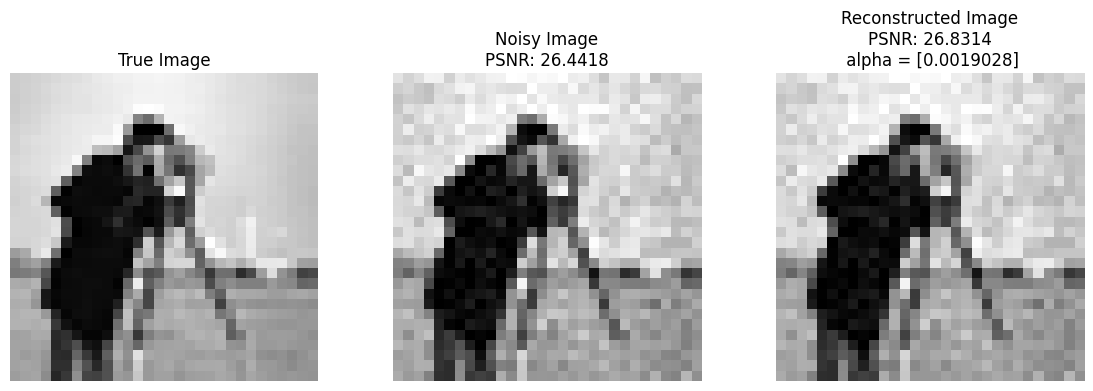

In [17]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)